In [1]:
import pandas as pd
import re
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from transformers import pipeline
import matplotlib.pyplot as plt


In [2]:
df = pd.read_csv('cleaned_dataset.csv')
text_column = "dummy_text"

In [3]:
nltk.download("stopwords")

# Define custom stopwords
custom_stopwords = set([
    "html", "https", "com", "click", "expand", "www", "http", "href", "class",
    "span", "div", "one", "would", "also", "like", "people", "even", "just",
    "could", "many", "much", "said", "trump", "us", "time", "know", "think",
    "see", "good", "wikipedia", "view", "attachment", "wiki", "totaldisclosure",
    "expand click", "highlightreply", "bbcode",
    "container", "stormfront org", "en org", "stormfront org forum",
    "channel httpstme", "join sgtnewsnetwork twitter", "co uk"
])
stop_words = set(stopwords.words("english")).union(custom_stopwords)

# Text Cleaning Function
def clean_text(text):
    if isinstance(text, str):
        text = BeautifulSoup(text, "html.parser").get_text()
        text = text.lower()
        text = re.sub(r"https?://\S+|www\.\S+", "", text)
        text = re.sub(r"[^\w\s]", "", text)
        text = re.sub(r"\b\d+\b", "", text)
        text = re.sub(r"\b[a-zA-Z]\b", "", text)
        text = re.sub(r"\s+\b[a-zA-Z]\b\s+", " ", text)
        text = re.sub(r"\b(?:span|class|div|href|onclick|highlightreply|bbcode|container)\b", "", text)
        text = re.sub(r"\b[a-zA-Z0-9]{15,}\b", "", text)
        text = re.sub(r"\s+", " ", text).strip()
        text = " ".join([word for word in text.split() if word not in stop_words])
        return text
    return ""

# Clean Text Column
df[text_column] = df[text_column].astype(str).apply(clean_text)


[nltk_data] Downloading package stopwords to
[nltk_data]     /users/PLS0150/arnobrahee/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
non_binary_cols = [col for col in df.columns if col != text_column and not set(df[col].dropna().unique()).issubset({0, 1})]
df = df.drop(columns=non_binary_cols)

# Final list of binary columns
binary_cols = [col for col in df.columns if col != text_column]

# Load HuggingFace Emotion Analysis Model
emotion_pipeline = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base", top_k=None)


Device set to use cuda:0


In [8]:
from transformers import AutoTokenizer

# Load tokenizer of your model
tokenizer = AutoTokenizer.from_pretrained("j-hartmann/emotion-english-distilroberta-base")

# Chunking based on tokens (not words)
def chunk_text_safely(text, max_tokens=450):
    words = text.split()
    chunks = []
    current_chunk = []

    current_len = 0
    for word in words:
        word_len = len(tokenizer.tokenize(word))
        if current_len + word_len > max_tokens:
            chunks.append(" ".join(current_chunk))
            current_chunk = [word]
            current_len = word_len
        else:
            current_chunk.append(word)
            current_len += word_len

    if current_chunk:
        chunks.append(" ".join(current_chunk))

    return chunks


In [10]:
import numpy as np

column_emotion_scores = {}

for col in binary_cols:
    print(f"Processing Emotion Analysis for: {col}")

    relevant_texts = df[df[col] == 1][text_column].dropna().tolist()

    if not relevant_texts:
        print(f"No text found for {col}, Skipping...")
        continue

    all_emotion_scores = []

    for text in relevant_texts:
        text_chunks = chunk_text_safely(text)
        for chunk in text_chunks:
            prediction = emotion_pipeline(chunk, top_k=None, truncation=True, max_length=512)
            emotion_score = {item['label']: item['score'] for item in prediction}
            all_emotion_scores.append(emotion_score)

    emotion_labels = all_emotion_scores[0].keys()
    avg_emotion_scores = {label: np.mean([score[label] for score in all_emotion_scores]) for label in emotion_labels}

    column_emotion_scores[col] = avg_emotion_scores


Processing Emotion Analysis for: st_benchmark
No text found for st_benchmark, Skipping...
Processing Emotion Analysis for: st_conspiracy
Processing Emotion Analysis for: st_healthmisinfo
Processing Emotion Analysis for: st_left
Processing Emotion Analysis for: st_mano
Processing Emotion Analysis for: st_paleo
Processing Emotion Analysis for: st_patriot
Processing Emotion Analysis for: st_qanon


Token indices sequence length is longer than the specified maximum sequence length for this model (603 > 512). Running this sequence through the model will result in indexing errors


Processing Emotion Analysis for: st_ernews
Processing Emotion Analysis for: st_altright
Processing Emotion Analysis for: st_religion
Processing Emotion Analysis for: sts_christian
Processing Emotion Analysis for: sts_chrnation
Processing Emotion Analysis for: sts_nationalist
Processing Emotion Analysis for: sts_prophecy
Processing Emotion Analysis for: sts_hyper
Processing Emotion Analysis for: sts_natsoc
Processing Emotion Analysis for: sts_newage
Processing Emotion Analysis for: sts_religother
Processing Emotion Analysis for: sts_erother
Processing Emotion Analysis for: sts_catholic
Processing Emotion Analysis for: disorder_frame
Processing Emotion Analysis for: disorder_frame_fq
No text found for disorder_frame_fq, Skipping...
Processing Emotion Analysis for: disorder_frame_wq
Processing Emotion Analysis for: disorder_accel_sub
Processing Emotion Analysis for: disorder_accel_sub_fq
No text found for disorder_accel_sub_fq, Skipping...
Processing Emotion Analysis for: disorder_accel_s

In [13]:
import matplotlib.pyplot as plt
import os

# Create a directory named 'emotions' if not already exists
os.makedirs('emotions', exist_ok=True)

# Function to plot and save the graph
def plot_emotion_distribution_and_save(col):
    emotion_scores = column_emotion_scores[col]
    labels = list(emotion_scores.keys())
    values = list(emotion_scores.values())

    plt.figure(figsize=(10, 6))
    bars = plt.bar(labels, values)

    # Add value labels on top of bars
    for bar, value in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
                 f'{value:.3f}',
                 ha='center', va='bottom', fontsize=10, color='black')

    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Average Emotion Score')
    plt.xlabel('Emotion Labels')
    plt.title(f'Emotion Distribution for: {col}', fontsize=14, fontweight='bold')
    plt.tight_layout()

    # Save the plot
    file_path = f'emotions/{col}.png'
    plt.savefig(file_path)
    plt.close()  # Close the figure to save memory

    print(f"Saved emotion plot for: {col} at {file_path}")

# Loop through all columns and save their emotion plots
for col in column_emotion_scores.keys():
    plot_emotion_distribution_and_save(col)


Saved emotion plot for: st_conspiracy at emotions/st_conspiracy.png
Saved emotion plot for: st_healthmisinfo at emotions/st_healthmisinfo.png
Saved emotion plot for: st_left at emotions/st_left.png
Saved emotion plot for: st_mano at emotions/st_mano.png
Saved emotion plot for: st_paleo at emotions/st_paleo.png
Saved emotion plot for: st_patriot at emotions/st_patriot.png
Saved emotion plot for: st_qanon at emotions/st_qanon.png
Saved emotion plot for: st_ernews at emotions/st_ernews.png
Saved emotion plot for: st_altright at emotions/st_altright.png
Saved emotion plot for: st_religion at emotions/st_religion.png
Saved emotion plot for: sts_christian at emotions/sts_christian.png
Saved emotion plot for: sts_chrnation at emotions/sts_chrnation.png
Saved emotion plot for: sts_nationalist at emotions/sts_nationalist.png
Saved emotion plot for: sts_prophecy at emotions/sts_prophecy.png
Saved emotion plot for: sts_hyper at emotions/sts_hyper.png
Saved emotion plot for: sts_natsoc at emotions

Plotting emotion distribution for: st_conspiracy


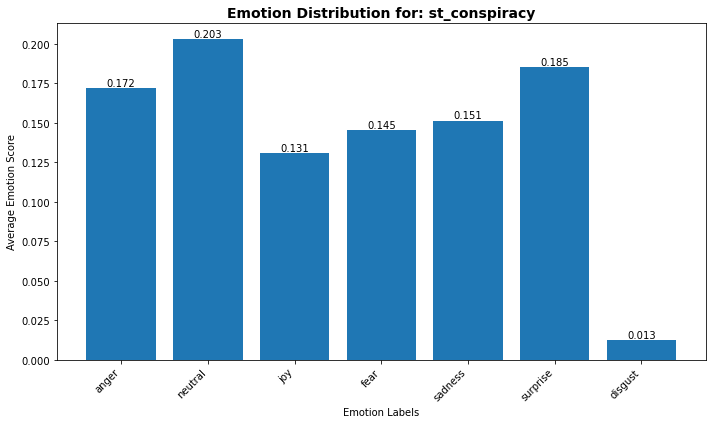

Plotting emotion distribution for: st_healthmisinfo


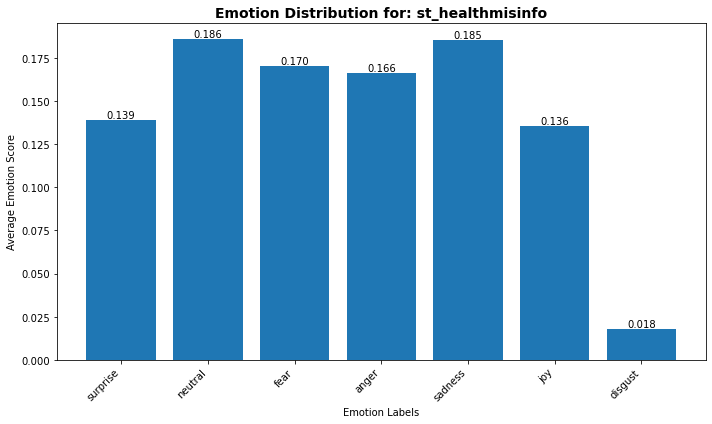

Plotting emotion distribution for: st_left


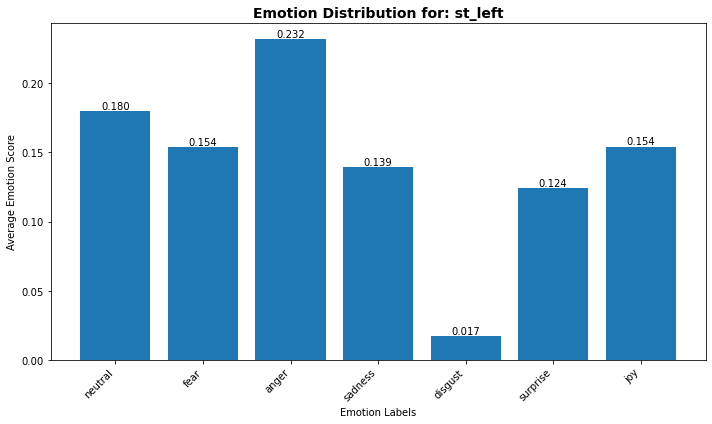

Plotting emotion distribution for: st_mano


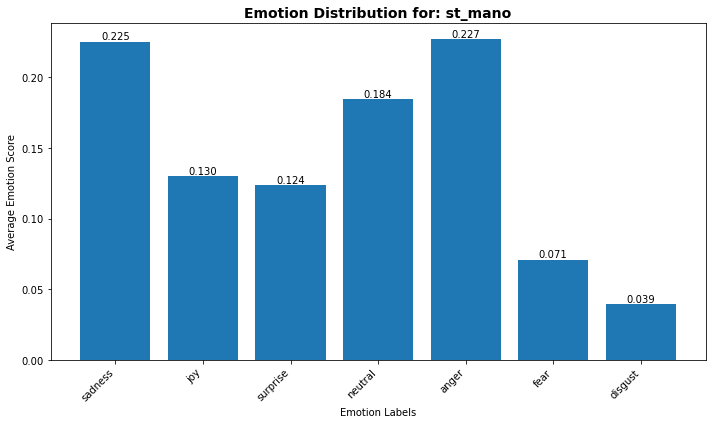

Plotting emotion distribution for: st_paleo


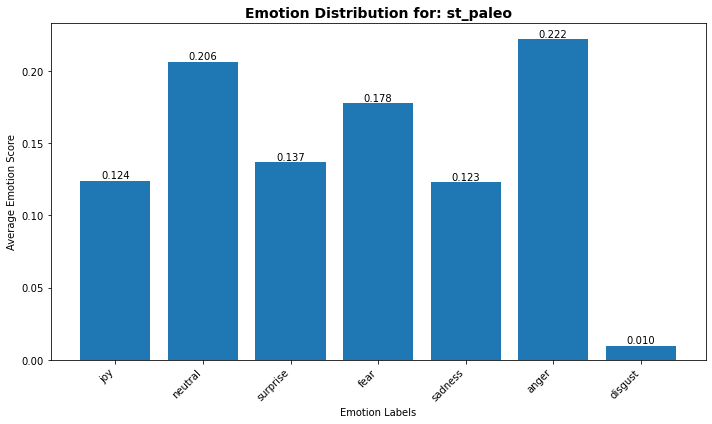

Plotting emotion distribution for: st_patriot


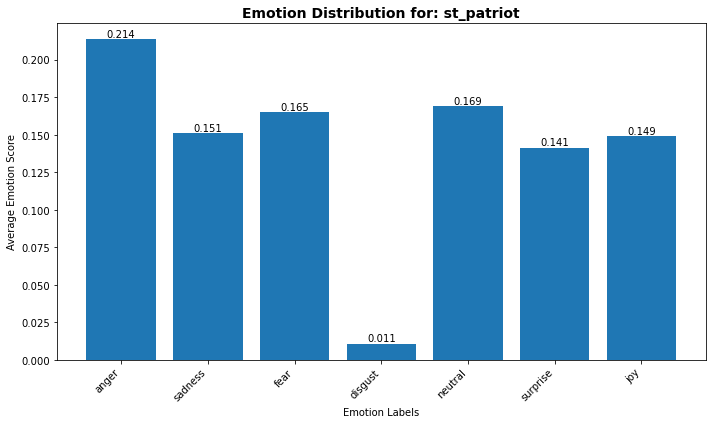

Plotting emotion distribution for: st_qanon


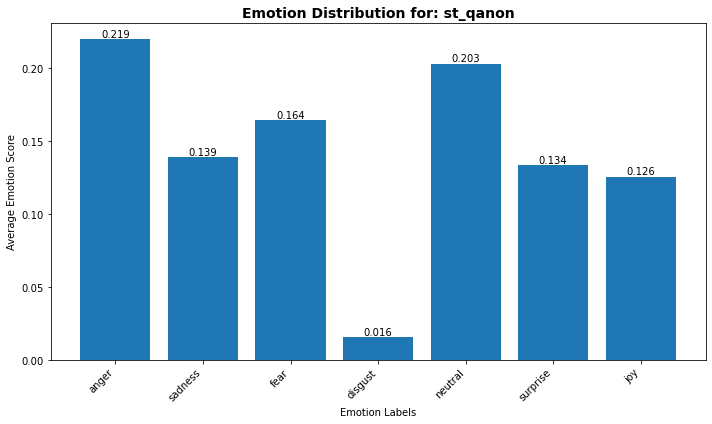

Plotting emotion distribution for: st_ernews


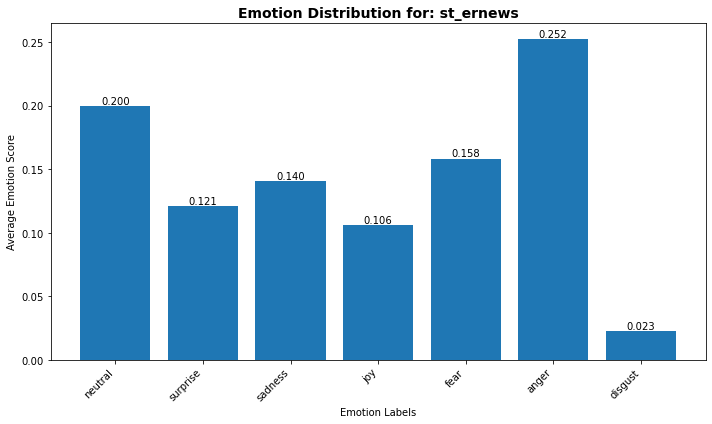

Plotting emotion distribution for: st_altright


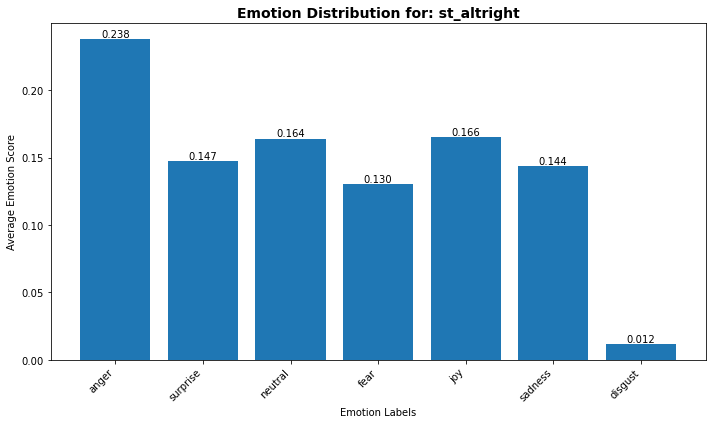

Plotting emotion distribution for: st_religion


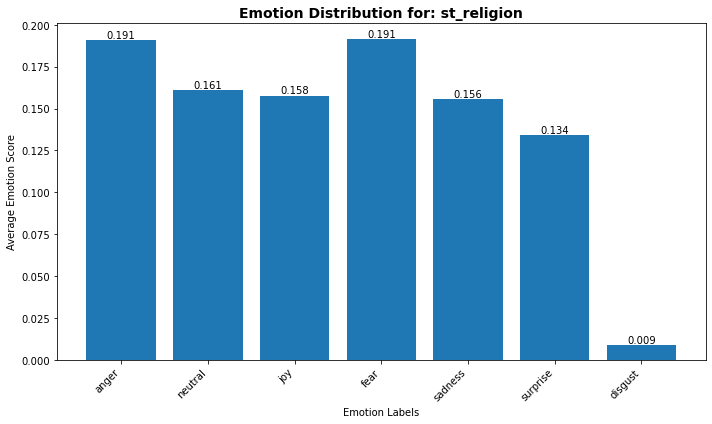

Plotting emotion distribution for: sts_christian


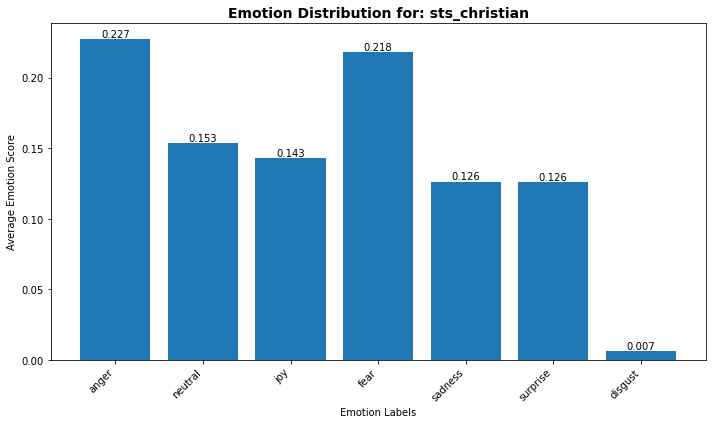

Plotting emotion distribution for: sts_chrnation


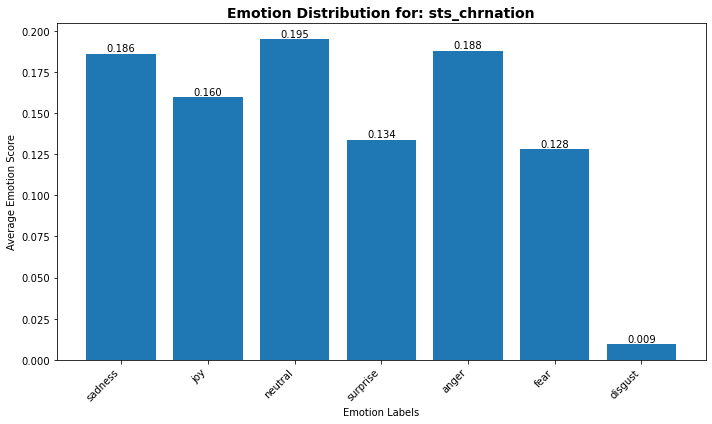

Plotting emotion distribution for: sts_nationalist


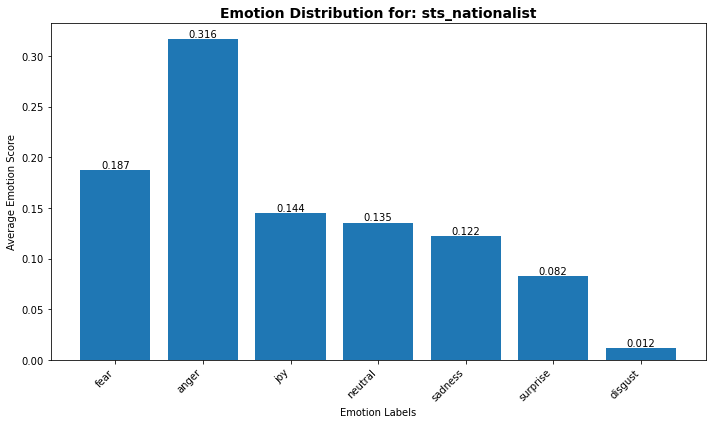

Plotting emotion distribution for: sts_prophecy


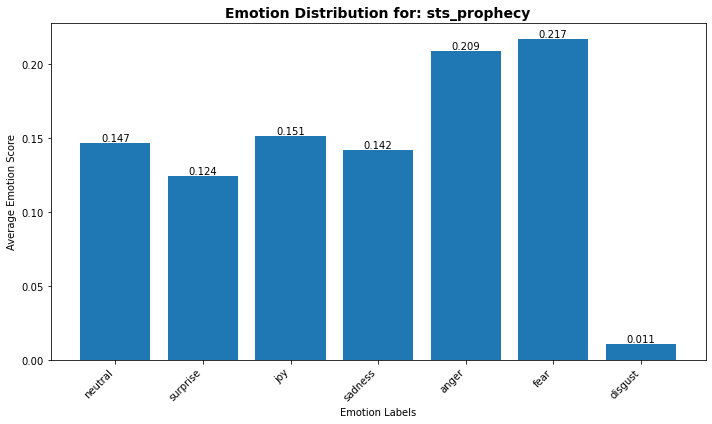

Plotting emotion distribution for: sts_hyper


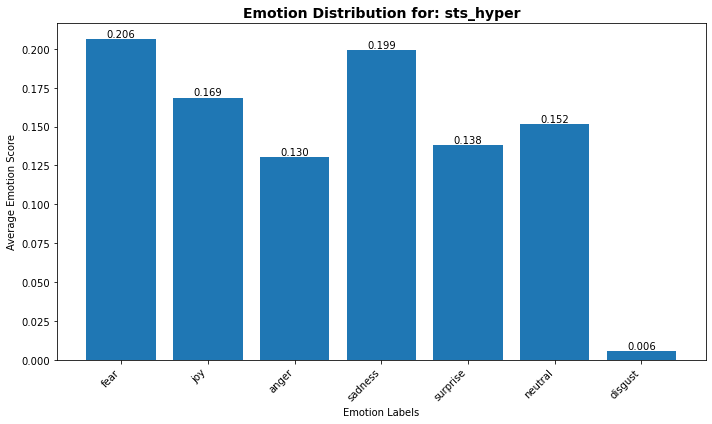

Plotting emotion distribution for: sts_natsoc


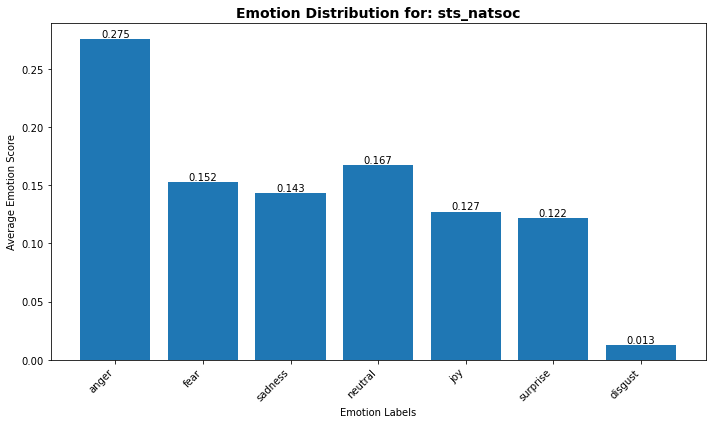

Plotting emotion distribution for: sts_newage


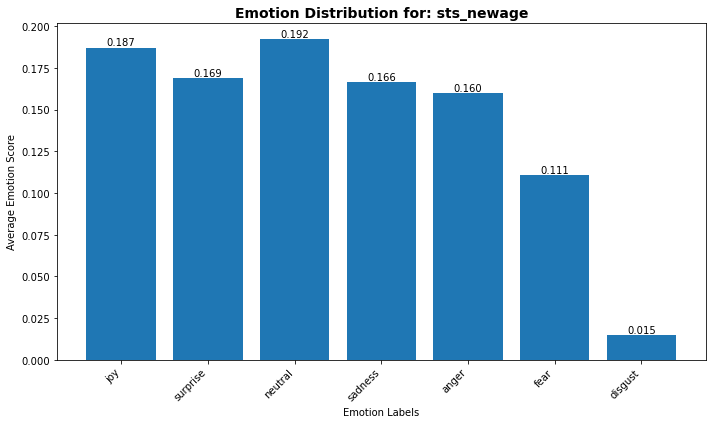

Plotting emotion distribution for: sts_religother


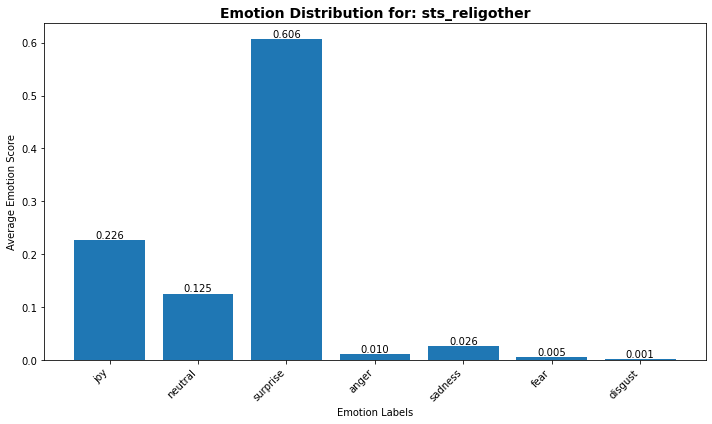

Plotting emotion distribution for: sts_erother


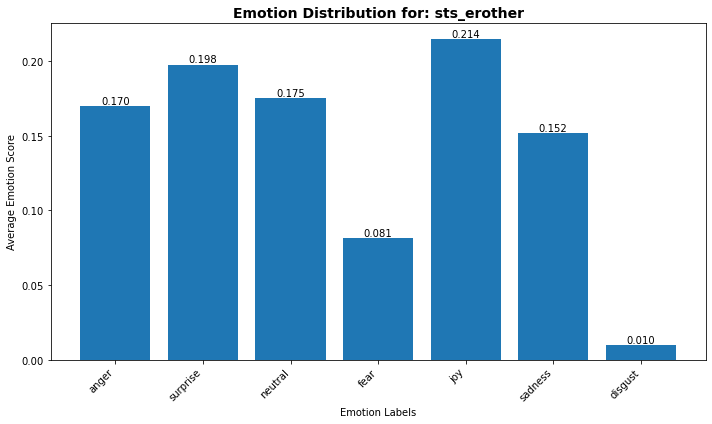

Plotting emotion distribution for: sts_catholic


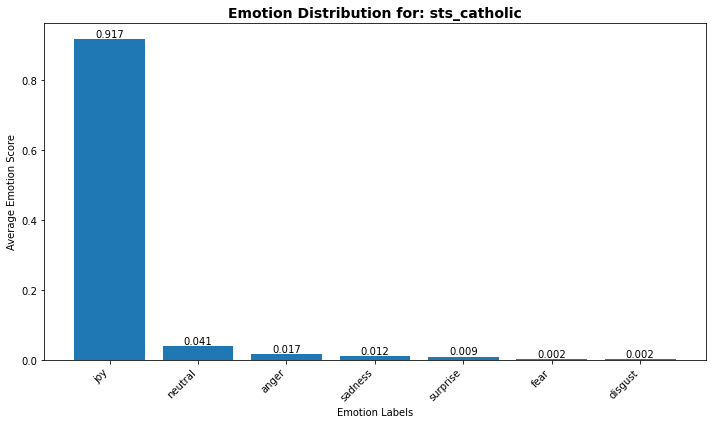

Plotting emotion distribution for: disorder_frame


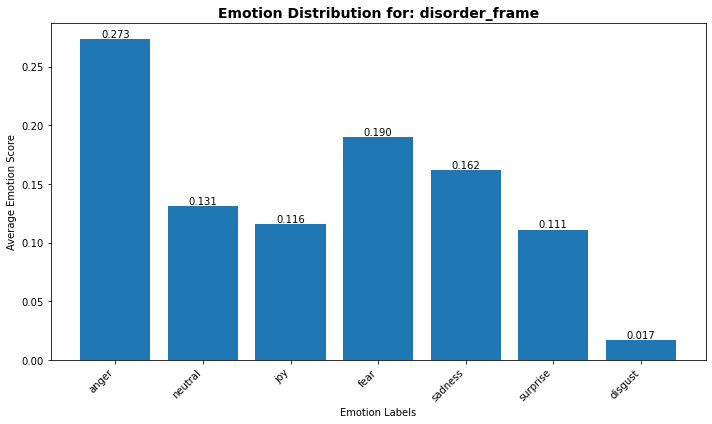

Plotting emotion distribution for: disorder_frame_wq


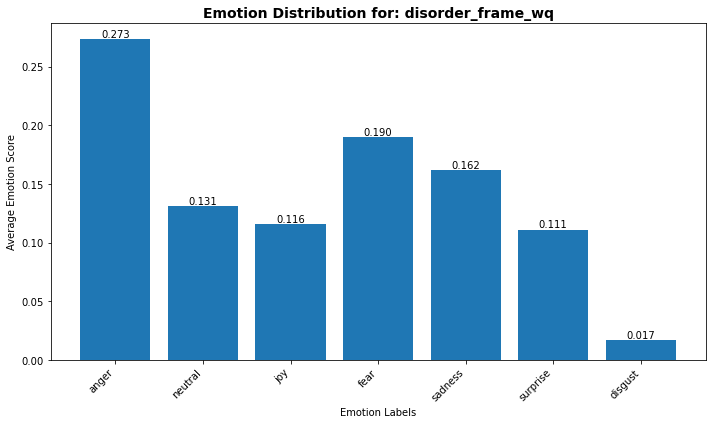

Plotting emotion distribution for: disorder_accel_sub


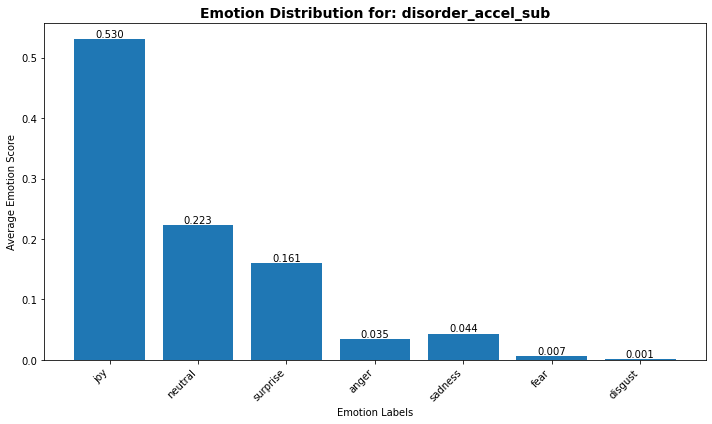

Plotting emotion distribution for: disorder_accel_sub_wq


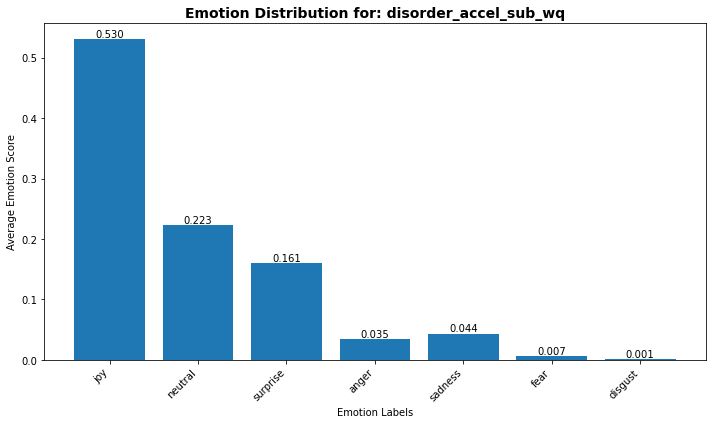

Plotting emotion distribution for: disorder_aggress_sub


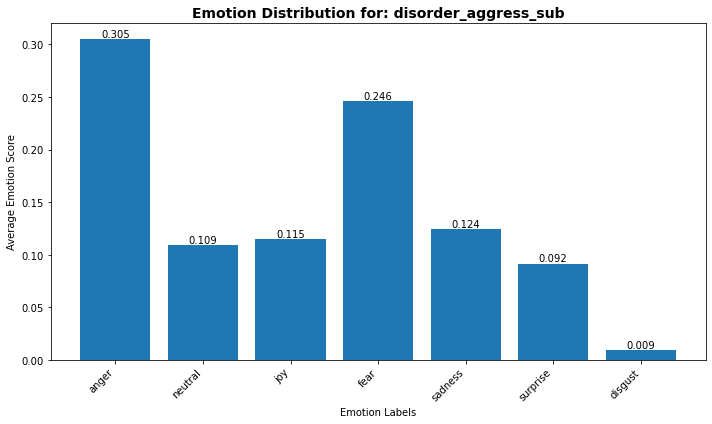

Plotting emotion distribution for: disorder_aggress_sub_wq


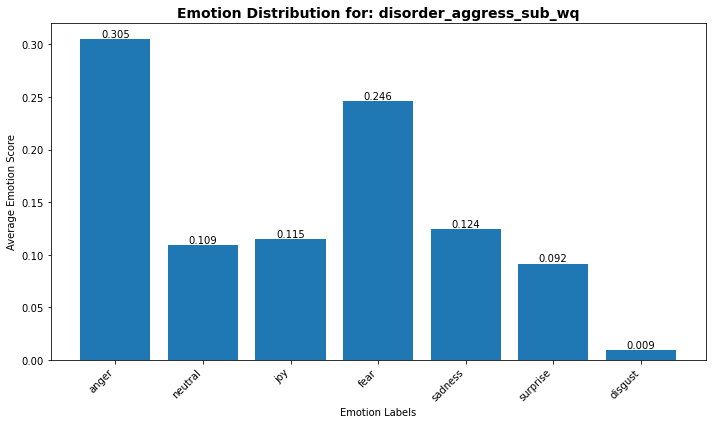

Plotting emotion distribution for: disorder_chaos_sub


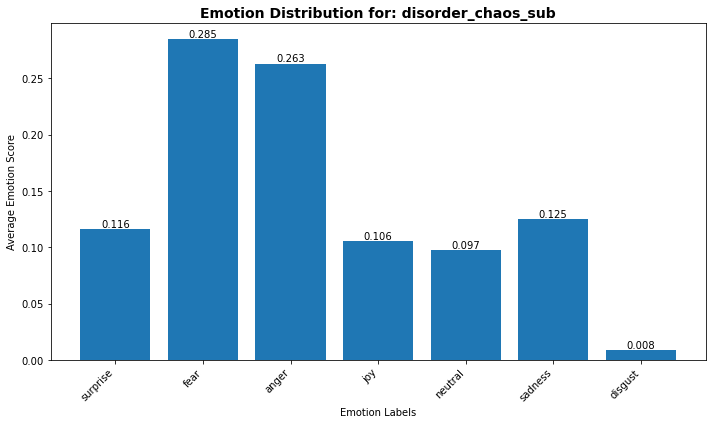

Plotting emotion distribution for: disorder_chaos_sub_wq


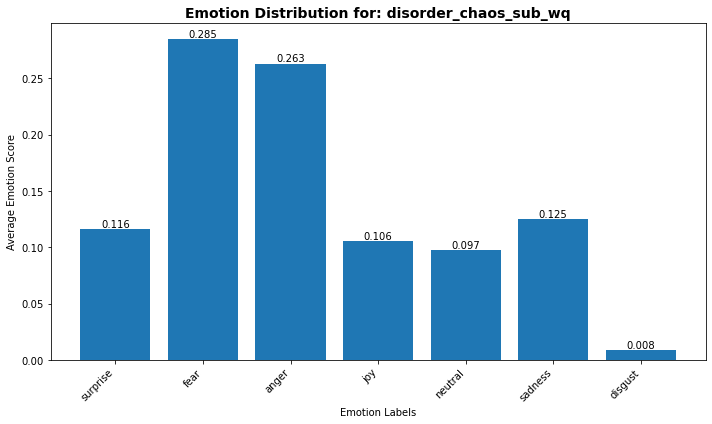

Plotting emotion distribution for: disorder_crime_sub


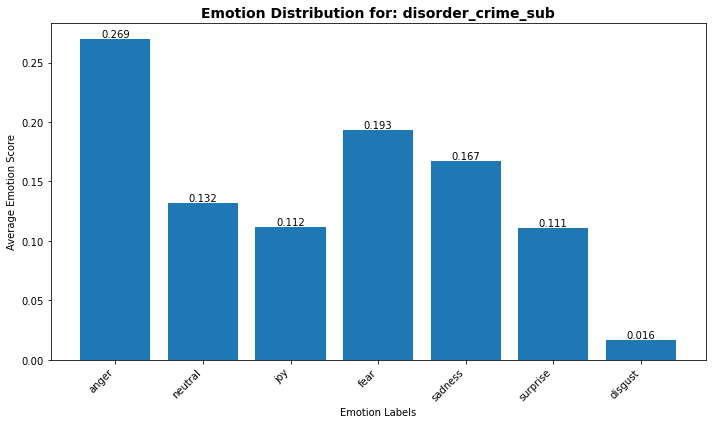

Plotting emotion distribution for: disorder_crime_sub_wq


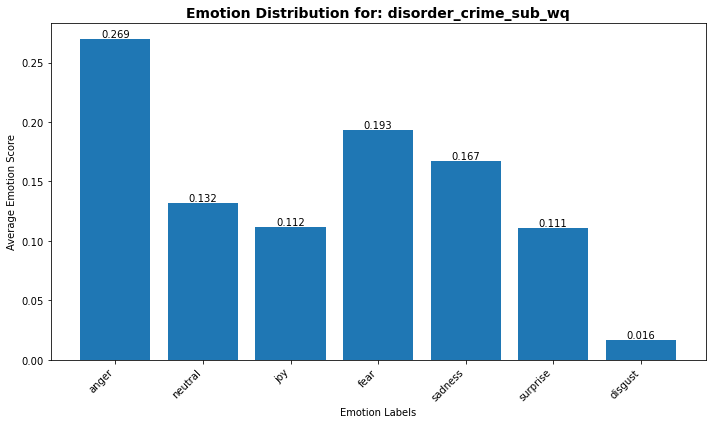

Plotting emotion distribution for: disorder_evil_sub


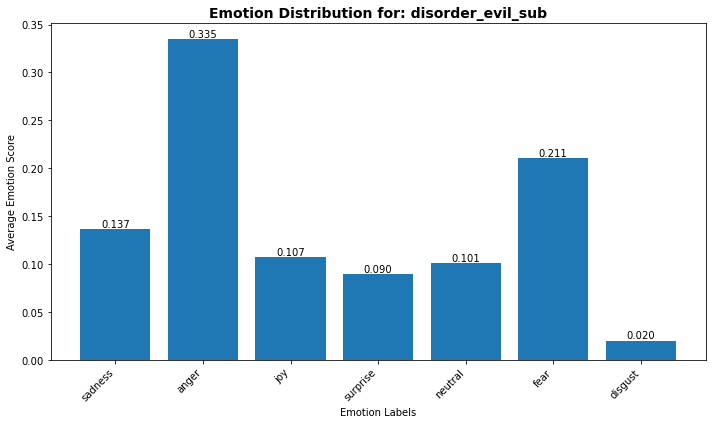

Plotting emotion distribution for: disorder_evil_sub_wq


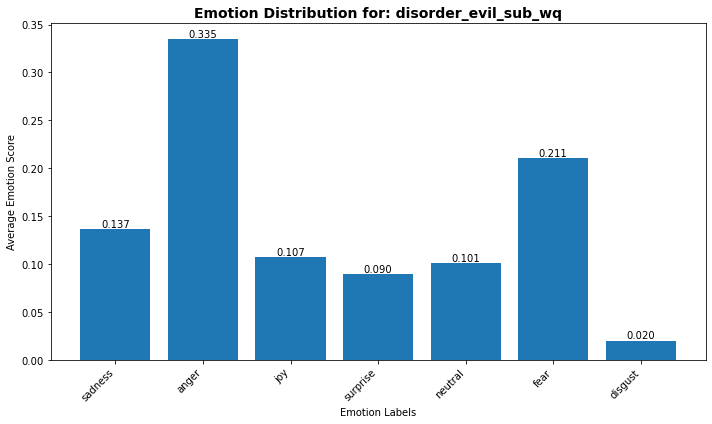

Plotting emotion distribution for: disorder_harm_sub


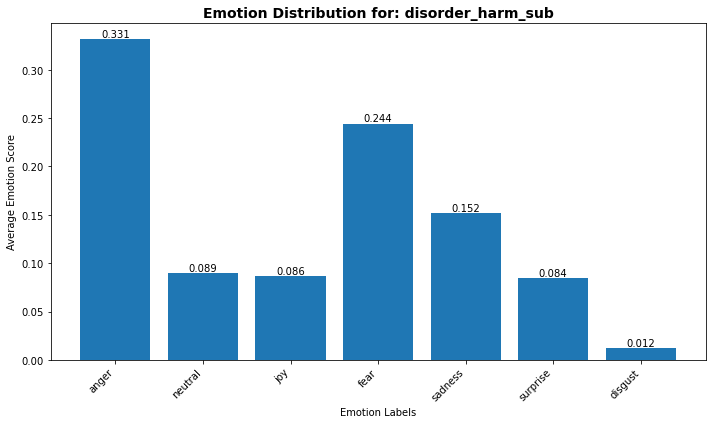

Plotting emotion distribution for: disorder_harm_sub_wq


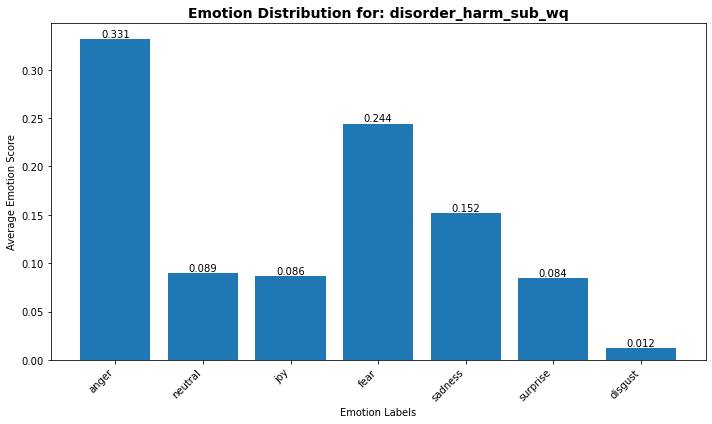

Plotting emotion distribution for: disorder_militarism_sub


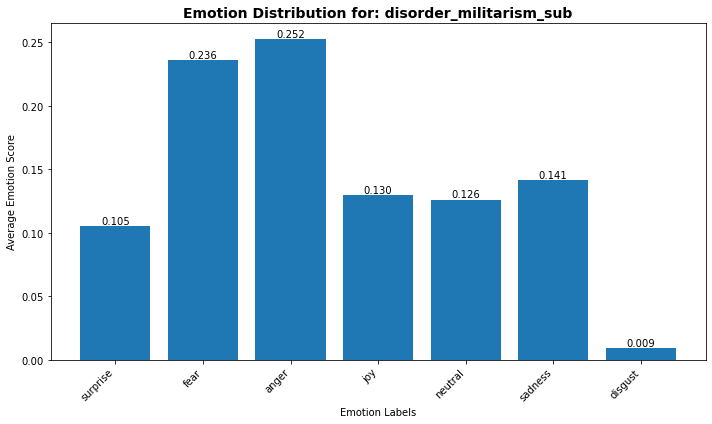

Plotting emotion distribution for: disorder_militarism_sub_wq


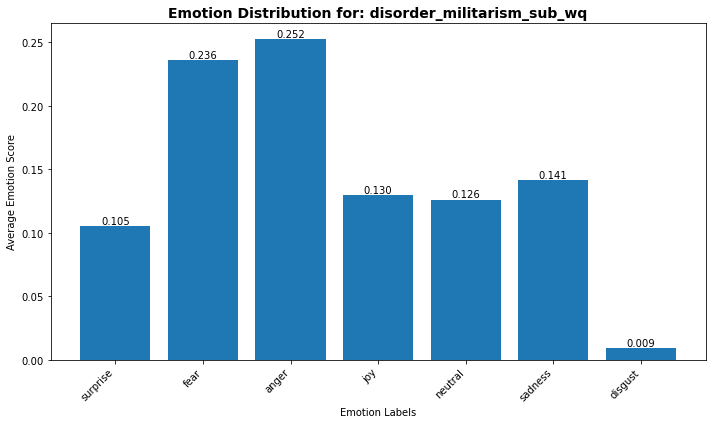

Plotting emotion distribution for: disorder_selfharm_sub


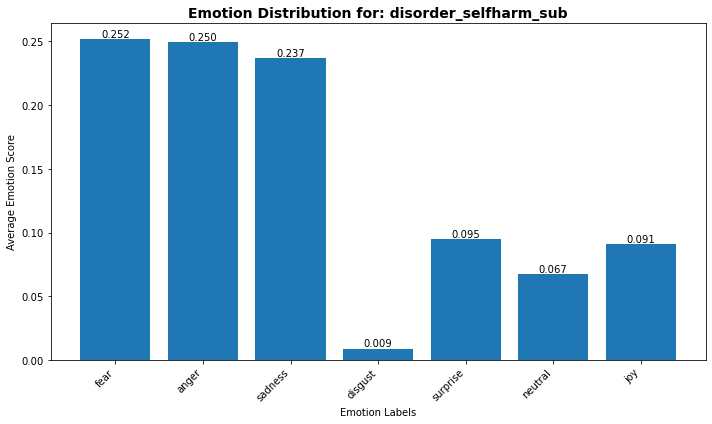

Plotting emotion distribution for: disorder_selfharm_sub_wq


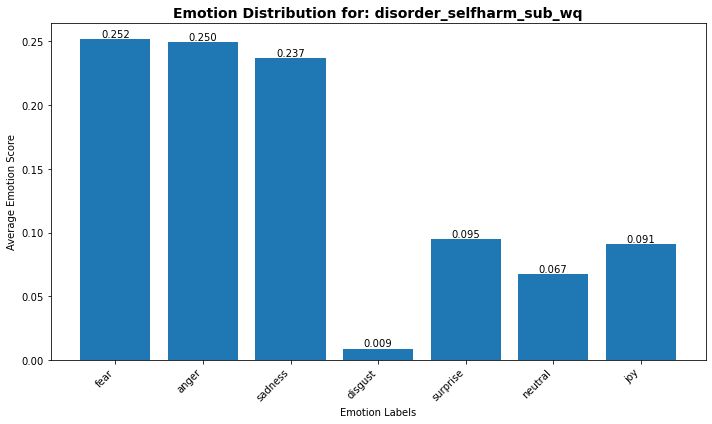

Plotting emotion distribution for: disorder_violence_combo


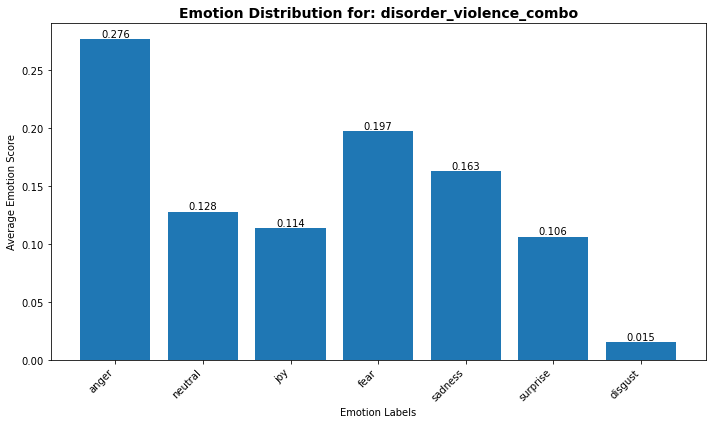

Plotting emotion distribution for: disorder_violence_combo_wq


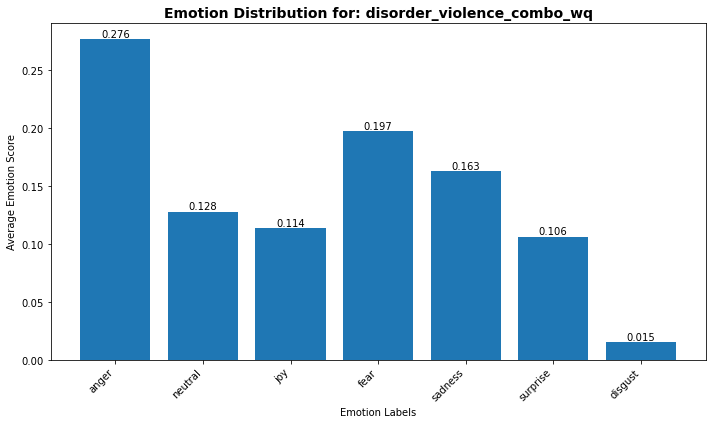

Plotting emotion distribution for: toxic_frame


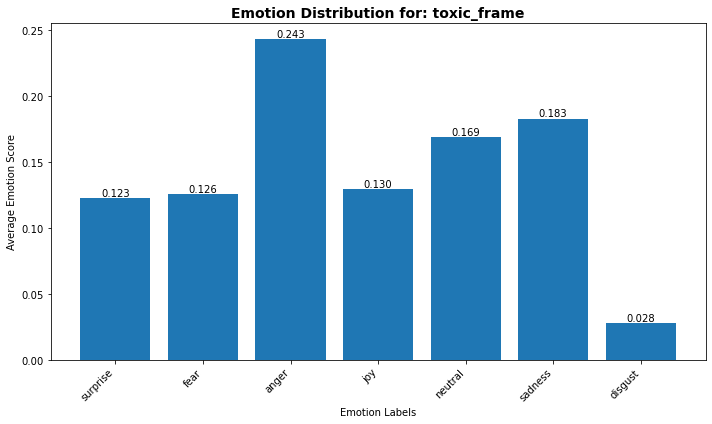

Plotting emotion distribution for: toxic_frame_fq


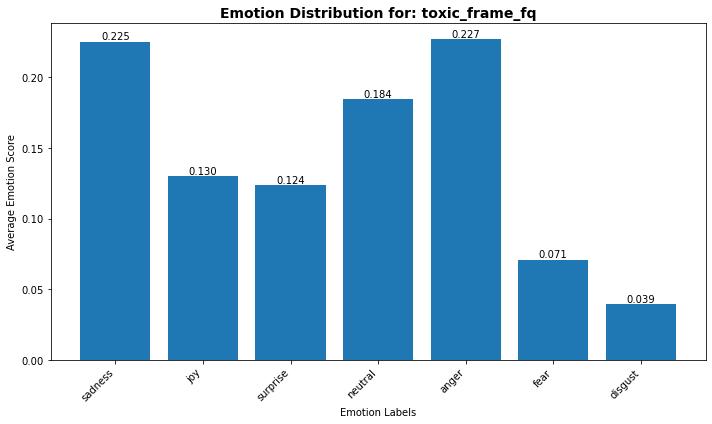

Plotting emotion distribution for: toxic_frame_wq


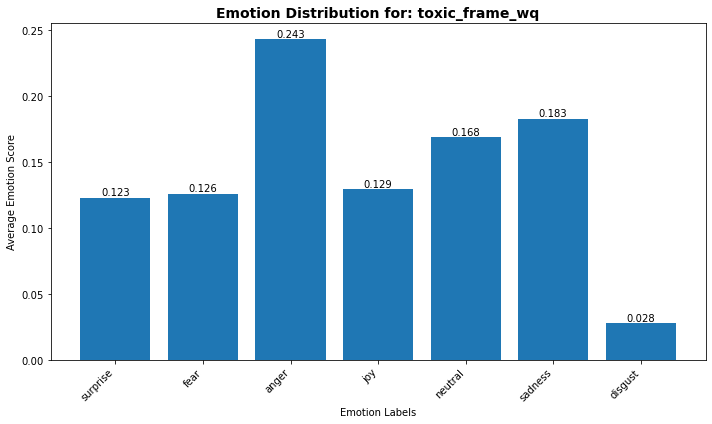

Plotting emotion distribution for: toxic_incel_sub


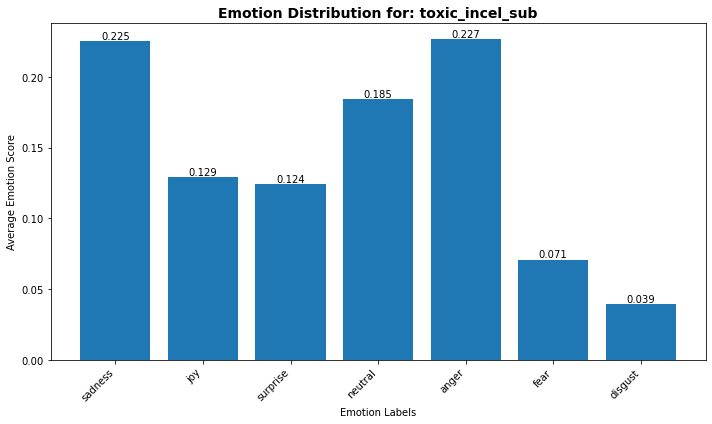

Plotting emotion distribution for: toxic_incel_sub_fq


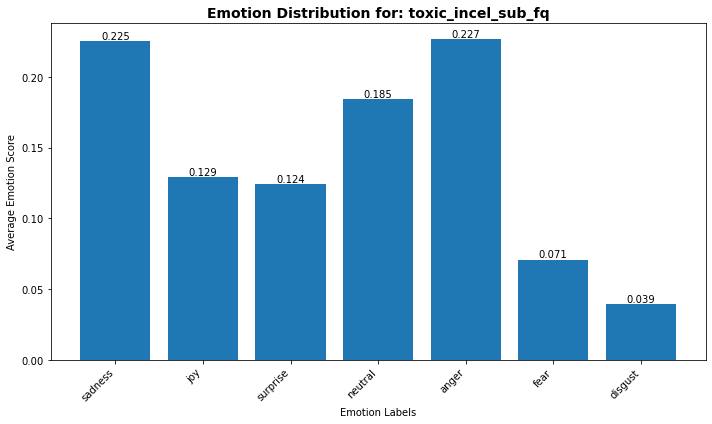

Plotting emotion distribution for: toxic_incel_sub_wq


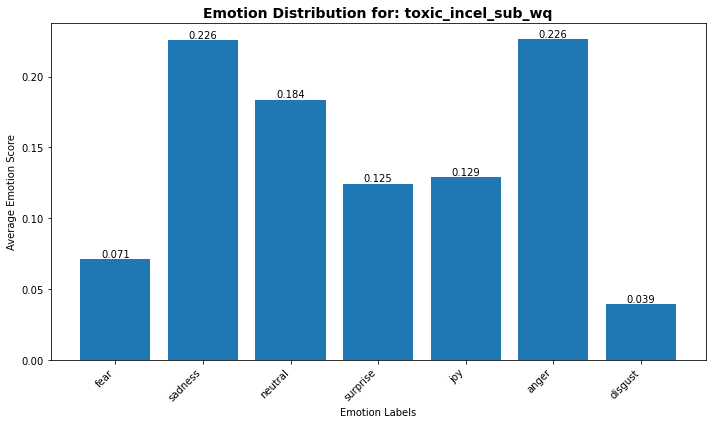

Plotting emotion distribution for: toxic_misogyny_sub


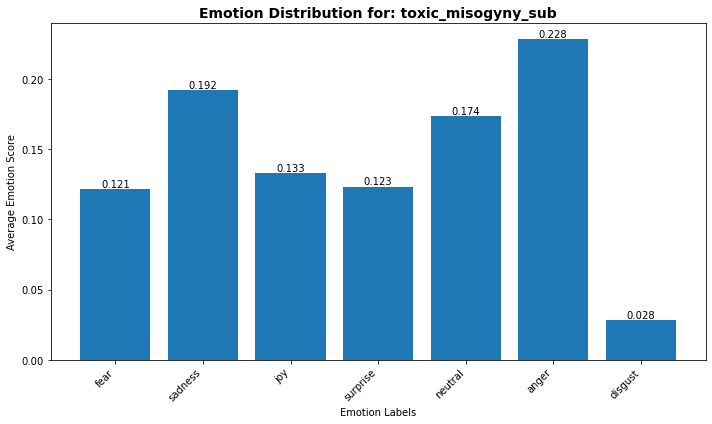

Plotting emotion distribution for: toxic_misogyny_sub_fq


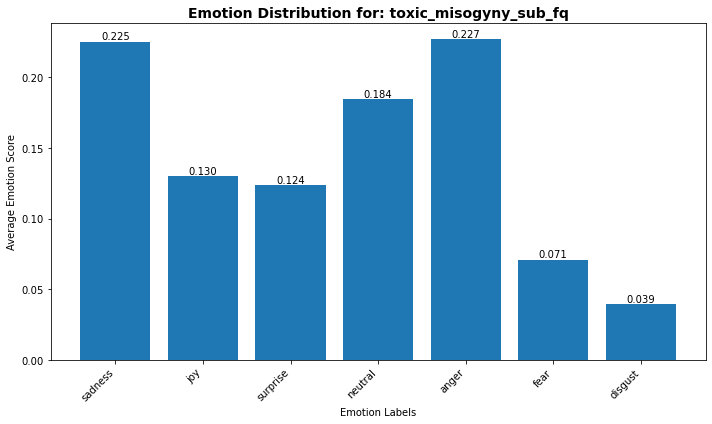

Plotting emotion distribution for: toxic_misogyny_sub_wq


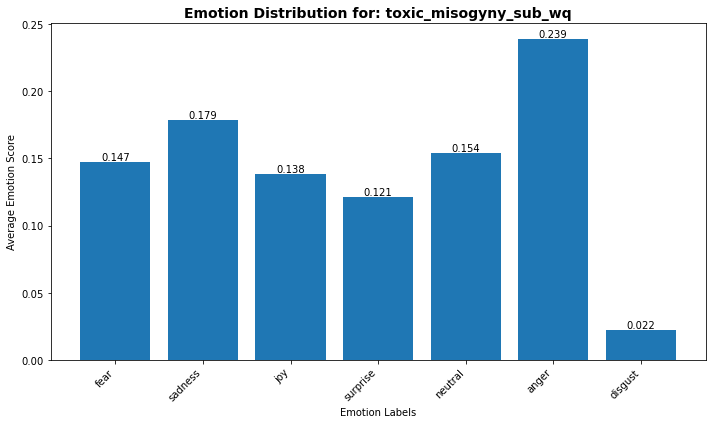

Plotting emotion distribution for: toxic_vulgar_sub


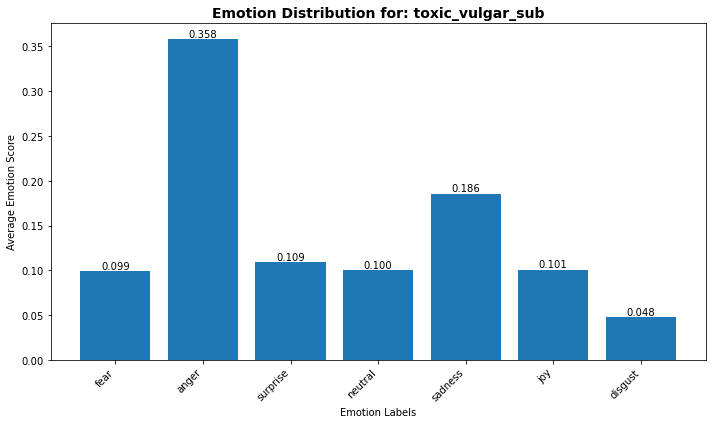

Plotting emotion distribution for: toxic_vulgar_sub_wq


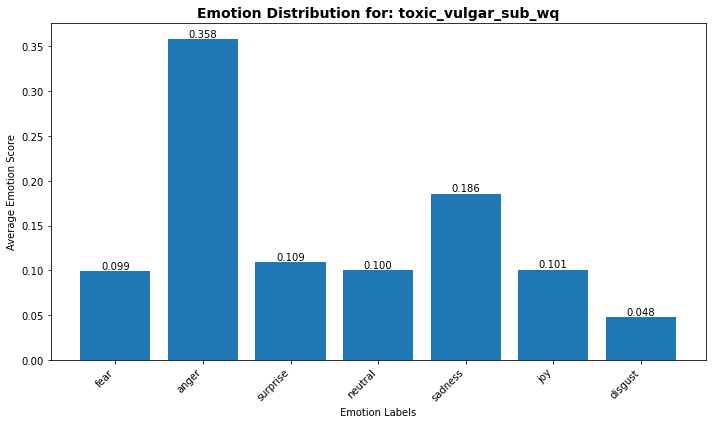

Plotting emotion distribution for: toxic_antisem_sub


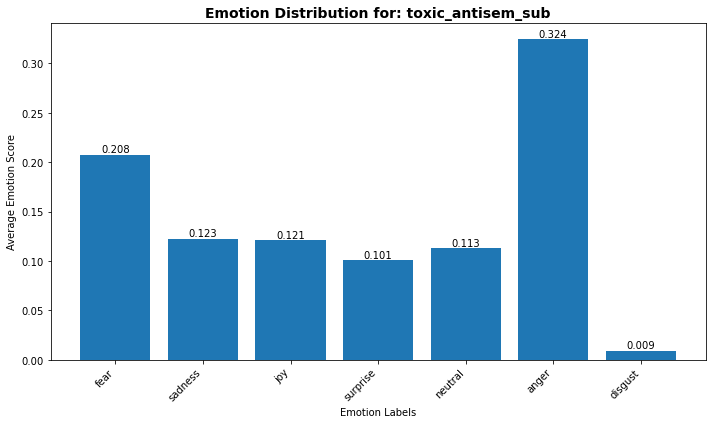

Plotting emotion distribution for: toxic_antisem_sub_wq


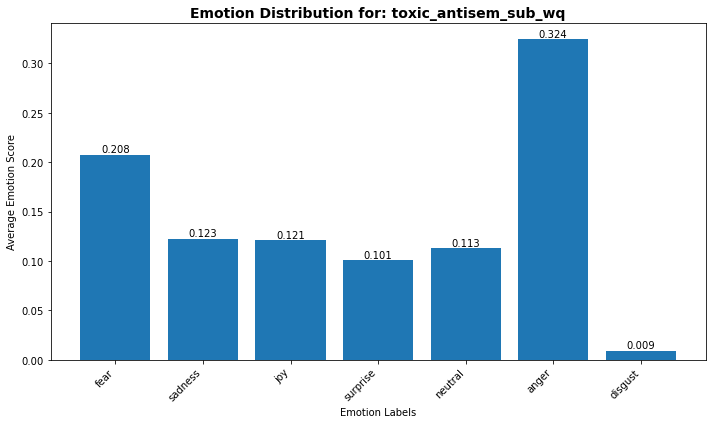

Plotting emotion distribution for: toxic_racism_sub


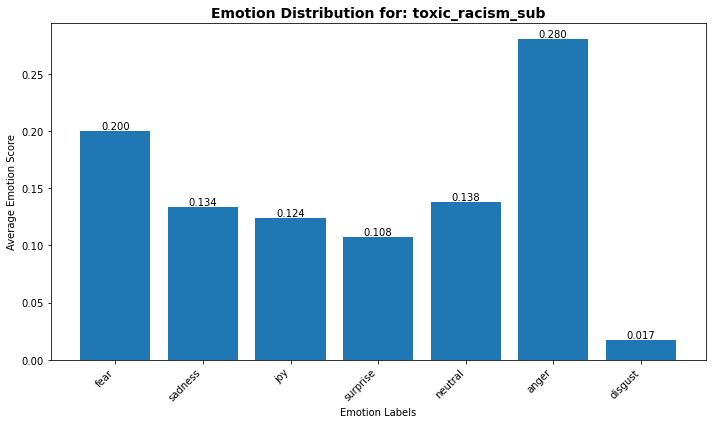

Plotting emotion distribution for: toxic_racism_sub_wq


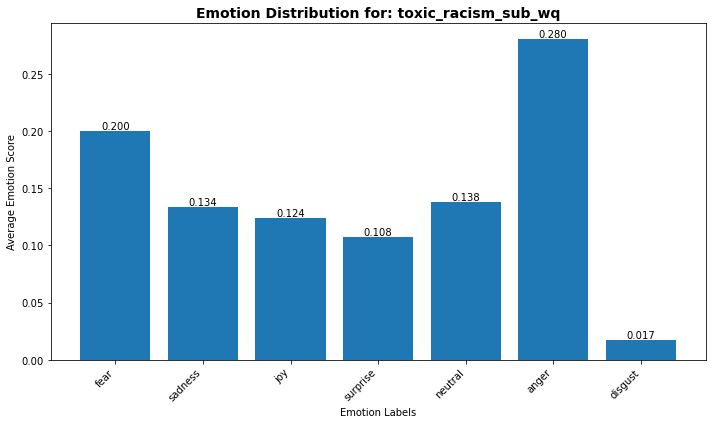

Plotting emotion distribution for: toxic_religvalues_sub


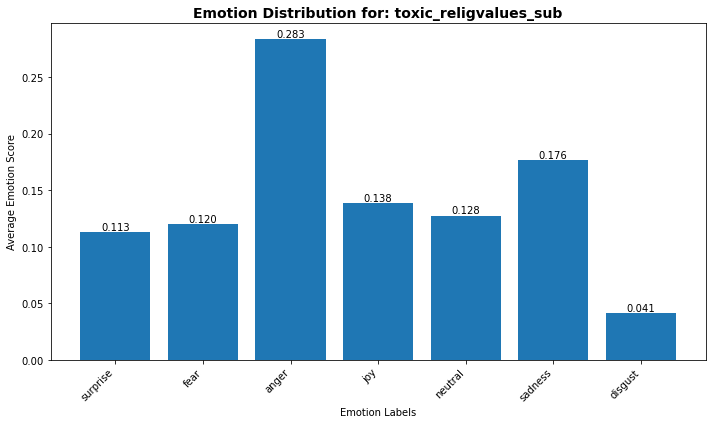

Plotting emotion distribution for: toxic_religvalues_sub_wq


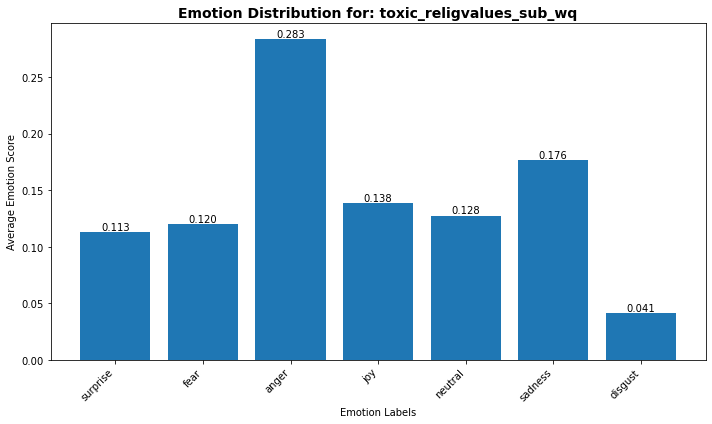

Plotting emotion distribution for: toxic_manosphere_combo


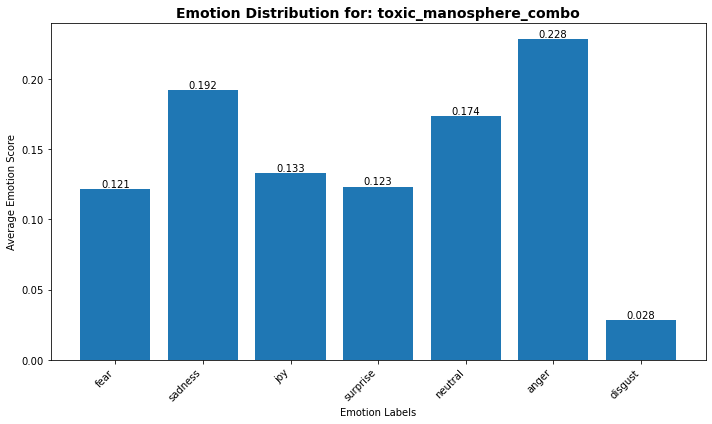

Plotting emotion distribution for: toxic_manosphere_combo_fq


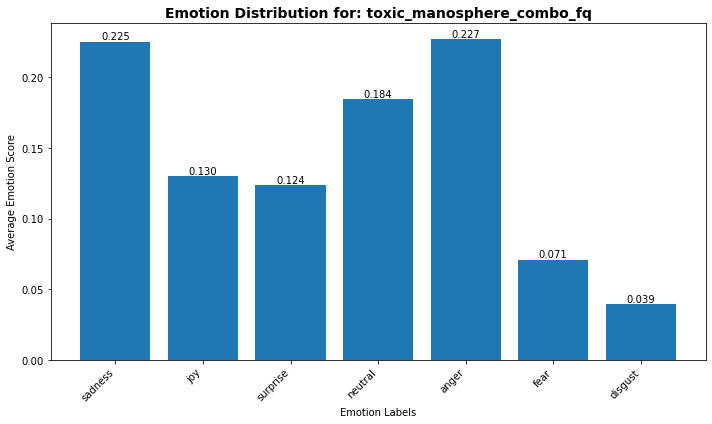

Plotting emotion distribution for: toxic_manosphere_combo_wc


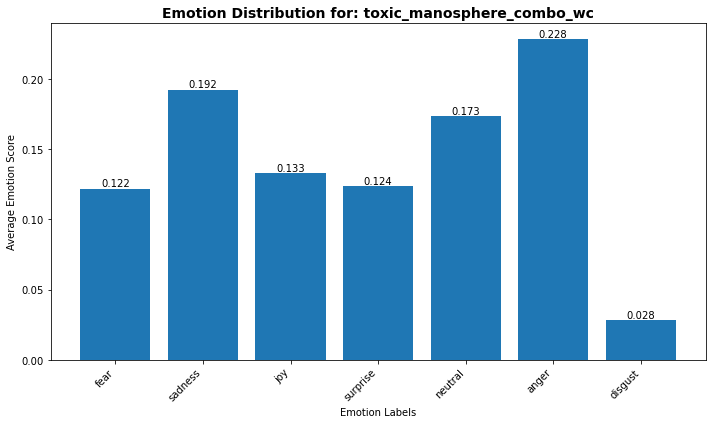

Plotting emotion distribution for: toxic_manosphere_combo_wq


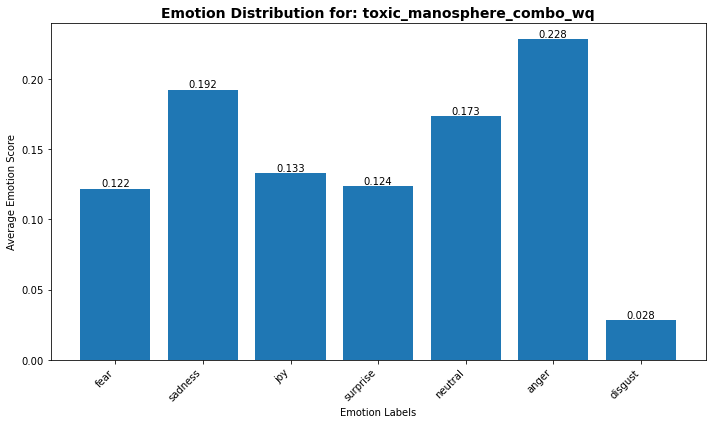

In [12]:
for col in column_emotion_scores.keys():
    print(f"Plotting emotion distribution for: {col}")
    plot_emotion_distribution(col)
